### Temporal bias maze vs remaze

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import subjects

sessions = subjects.nsd.re_maze + subjects.sd.re_maze

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from neuropy.utils.neurons_util import calculate_neurons_ccg

bias_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    get_bias = lambda epoch: calculate_neurons_ccg(
        neurons.time_slice(epoch[0], epoch[1])
    )

    pre_bias = get_bias(pre)
    maze_bias = get_bias(maze)
    remaze_bias = get_bias(remaze)

    bias_df.append(
        pd.DataFrame(
            dict(pre=pre_bias, maze=maze_bias, remaze=remaze_bias, grp=sess.tag)
        )
    )


bias_df = pd.concat(bias_df, ignore_index=True)
subjects.GroupData().save(bias_df, "remaze_temporal_bias")

100%|██████████| 6/6 [00:21<00:00,  3.65s/it]

remaze_temporal_bias saved


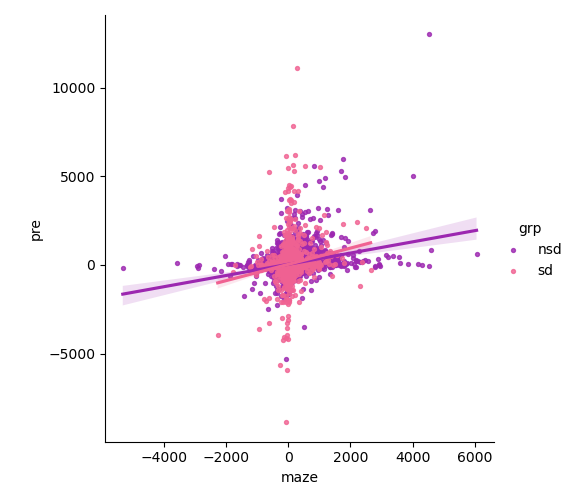

In [ ]:
%matplotlib widget
import seaborn as sns

sns.lmplot(
    data=bias_df,
    x="maze",
    y="pre",
    hue="grp",
    palette=["#9C27B0", "#F06292"],
    # x_partial="pre",
    # y_partial="pre",
    scatter_kws={'s':8},
    # col='grp',
)


### Example radon transform figures

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from neuropy import plotting
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d
from neuropy.analyses.decoders import radon_transform
from hfuncs import radon_transform_gpu
from time import time

s = time()
for i in range(100):
    radon_transform(np.ones((50,10)))
e = time()
print(e-s)

s = time()
for i in range(5000):
    radon_transform_gpu(np.ones((50,10)))
e = time()
print(e-s)


# sess = subjects.nsd.ratUday2[0]

# maze = sess.paradigm["maze"].flatten()
# post = sess.paradigm["post"].flatten()
# neurons = sess.neurons.get_neuron_type(neuron_type="pyr")
# pos = sess.maze
# # pos.t_start = pos.t_start - 0.5
# run = sess.run
# pf = Pf1D(
#     neurons=neurons,
#     position=pos,
#     speed_thresh=4,
#     sigma=4,
#     grid_bin=2,
#     epochs=run,
#     frate_thresh=1,
# )
# # np.random.default_rng().shuffle(pf.tuning_curves)
# pf_neurons = neurons.get_by_id(pf.neuron_ids)
# epochs = sess.pbe.time_slice(maze[0], maze[0]+500)
# decode = Decode1d(
#     neurons=pf_neurons, ratemap=pf, epochs=epochs, bin_size=0.02
# )

In [ ]:
%matplotlib widget
import cupy as cp
from numpy.random import default_rng
from neuropy.analyses.decoders import radon_transform
from hfuncs import radon_transform_gpu
from neuropy import plotting
from scipy import stats
from neuropy.utils.mathutil import min_max_scaler
import time
from joblib import Parallel,delayed

n_posteriors = len(decode.posterior)
posterior_ind = default_rng().integers(0,n_posteriors,n_posteriors)
# posterior_ind = [382, 42, 131, 162, 287, 284, 127, 331, 294, 205]
# posterior_ind =[189, 139, 180, 178, 188, 103, 158,  15, 123, 156]
# posterior_ind= [ 7, 126, 114, 116, 115]
arrs = [decode.posterior[i] for i in posterior_ind]
len_arr = np.cumsum([_.shape[1] for _ in arrs])[:-1]
zsc_tuning = stats.zscore(pf.tuning_curves,axis=1)
sort_ind = np.argsort(np.argmax(zsc_tuning,axis=1))
post_gpu = cp.asarray(np.hstack(arrs)) 

s = time.time()
arrs_gpu = cp.hsplit(post_gpu,len_arr)
for i, arr in enumerate(arrs_gpu):
    
    score, velocity, intercept = radon_transform_gpu(arr, dt=0.02, dx=2, neighbours=4)

e = time.time()
print(e-s)

# s = time.time()
# for i, arr in enumerate(arrs):
#     t_start = epochs[posterior_ind[i]].flatten()[0]
#     score, velocity, intercept = radon_transform(arr, dt=0.02, dx=2, neighbours=4)
# e = time.time()
# print(e-s)

s = time.time()
results = Parallel(n_jobs=5)(
            delayed(radon_transform)(
                epoch,
                dt=0.02,
                dx=2,
                neighbours=4,
            )
            for epoch in arrs
        )
score, velocity, intercept = np.asarray(results).T
e = time.time()
print(e-s)




In [ ]:
%matplotlib widget
from numpy.random import default_rng
from neuropy.analyses.decoders import radon_transform_gpu,radon_transform
from neuropy import plotting
from scipy import stats
from neuropy.utils.mathutil import min_max_scaler
import time

n_posteriors = len(decode.posterior)
posterior_ind = default_rng().integers(0,n_posteriors,5)
# posterior_ind = [382, 42, 131, 162, 287, 284, 127, 331, 294, 205]
# posterior_ind =[189, 139, 180, 178, 188, 103, 158,  15, 123, 156]
# posterior_ind= [ 7, 126, 114, 116, 115]
arrs = [decode.posterior[i] for i in posterior_ind]

_, axs = plt.subplots(2, 5,sharey='row',sharex='col')
# axs = axs.reshape(-1)
zsc_tuning = stats.zscore(pf.tuning_curves,axis=1)
sort_ind = np.argsort(np.argmax(zsc_tuning,axis=1))

s = time.time()
for i, arr in enumerate(arrs):
    # arr = min_max_scaler(arr,axis=0)
    t_start = epochs[posterior_ind[i]].flatten()[0]

    score, velocity, intercept = radon_transform_gpu(arr, dt=0.02, dx=2, neighbours=4)
    # arr = np.apply_along_axis(np.convolve, axis=0, arr=arr, v=np.ones(2 * 4 + 1))
    # t = np.arange(arr.shape[1]) * 0.02+t_start
    # pos = np.arange(arr.shape[0]) * 2

    # axs[0,i].pcolormesh(t, pos,arr, cmap="hot")
    # axs[0,i].plot(t, velocity * (t-t_start) + intercept, color="w")
    # axs[0,i].set_ylim([pos.min(), pos.max()])
    # axs[0,i].set_title(score.round(2))

    # plotting.plot_raster(pf_neurons[sort_ind].time_slice(t_start=t[0],t_stop=t[-1]),ax=axs[1,i],color='k')
e = time.time()
print(e-s)

s = time.time()
for i, arr in enumerate(arrs):
    # arr = min_max_scaler(arr,axis=0)
    t_start = epochs[posterior_ind[i]].flatten()[0]

    score, velocity, intercept = radon_transform(arr, dt=0.02, dx=2, neighbours=4)
    # arr = np.apply_along_axis(np.convolve, axis=0, arr=arr, v=np.ones(2 * 4 + 1))
    # t = np.arange(arr.shape[1]) * 0.02+t_start
    # pos = np.arange(arr.shape[0]) * 2

    # axs[0,i].pcolormesh(t, pos,arr, cmap="hot")
    # axs[0,i].plot(t, velocity * (t-t_start) + intercept, color="w")
    # axs[0,i].set_ylim([pos.min(), pos.max()])
    # axs[0,i].set_title(score.round(2))

    # plotting.plot_raster(pf_neurons[sort_ind].time_slice(t_start=t[0],t_stop=t[-1]),ax=axs[1,i],color='k')
e = time.time()
print(e-s)


### Decoding here

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2

In [75]:
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type(neuron_type="pyr")
    pos = sess.maze
    pos.t_start = pos.t_start - 0.5
    # run = sess.run
    pf = Pf1D(
        neurons=neurons,
        position=pos,
        speed_thresh=5,
        sigma=4,
        grid_bin=2,
        # epochs=run,
        frate_thresh=1,
    )
    pf_neurons = neurons.get_by_id(pf.neuron_ids)
    epochs = sess.pbe.time_slice(maze[0], maze[0]+500)
    decode = Decode1d(
        neurons=pf_neurons, ratemap=pf, epochs=epochs, bin_size=0.02, decode_margin=15,nlines=8000
    )


In [86]:
r = decode.weighted_correlation(decode.posterior)

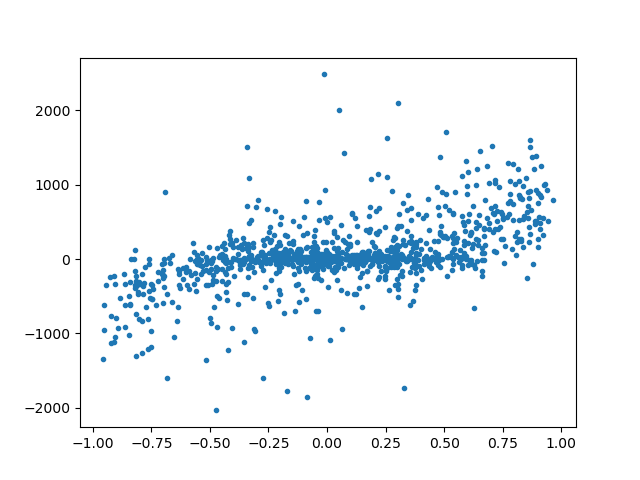

In [96]:
%matplotlib widget
# decode.plot_summary()
plt.plot(r,decode.velocity,'.')

In [ ]:
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot

# bplot.output_file(subjects.figpath_sd/'test_wake_decoding.html')
bplot.output_notebook()
p = plot_in_bokeh(
    x=epochs.starts / 3600,
    y=decode.score,
    img_arr=decode.posterior,
    color_by=decode.score,
    palette="jet",
    size=10,
)
# p.line(pos.time,pos.x/350 + 0.2,line_width=2,color='black')
bplot.show(p)


### Plotting decoding stats if calculated via script

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2

In [ ]:
for sub,sess in enumerate(sessions):

    replay_pbe= sess.replay_pbe

In [ ]:
from hfuncs import plot_replay_in_bokeh
import bokeh.plotting as bplot

bplot.output_notebook()
# bplot.output_file(subjects.figpath_sd/'test_wake_decoding.html')
p = plot_replay_in_bokeh(sess.replay_pbe)

# p.line(pos.time,pos.x/350 + 0.2,line_width=2,color='black')
bplot.show(p)

### Signficant sequences histogram

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
replay_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()
    is_replay = replay_pbe.is_replay
    velocity_bool = np.abs(replay_pbe.velocity.values)>100

    sig_events = np.logical_and(is_replay,velocity_bool)
    starts = replay_pbe.start.values[sig_events]
    bins = np.arange(post[0], post[0] + 2 * 3600, 600)
    hist_replay = np.histogram(starts, bins)[0]
    replay_df.append(
        pd.DataFrame(
            {"bins": ((bins[:-1] - post[0])/3600).round(2), "hist": hist_replay, "grp": sess.tag}
        )
    )

replay_df = pd.concat(replay_df, ignore_index=True)


In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2,2))
ax = fig.subplot(fig.gs[0])
sns.barplot(data=replay_df,x='bins',y='hist',hue='grp')


### Mean replay score across all events as a function of time 

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
from scipy import stats

replay_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()
    starts = sess.replay_pbe.starts
    replay_score = replay_pbe.score
    bins = np.arange(post[0], post[0] + 2 * 3600, 600)

    mean_score = stats.binned_statistic(starts, replay_score, bins=bins)[0]
    replay_df.append(
        pd.DataFrame(
            {
                "bins": ((bins[:-1] - post[0]) / 3600).round(2),
                "hist": mean_score,
                "grp": sess.tag,
            }
        )
    )

replay_df = pd.concat(replay_df, ignore_index=True)


In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2,2))
ax = fig.subplot(fig.gs[0])
sns.lineplot(data=replay_df,x='bins',y='hist',hue='grp')


### Distribution of replay scores and comparison with shuffled scores

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
from scipy import stats

score_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()

    starts = sess.replay_pbe.starts
    replay_score = replay_pbe.score

    shuffle_scores = sess.replay_pbe.metadata["shuffle_score"].flatten()
    shuffle_starts = np.repeat(starts, 200)
    
    bins = np.arange(2)*3600 + post[0]
    replay_df = pd.DataFrame(
        {
            "Zt":np.digitize(starts,bins),
            "starts": starts,
            "score": replay_score,
            "grp": sess.tag,
        }
    )
    shuffle_df = pd.DataFrame(
        {
            "Zt":np.digitize(shuffle_starts,bins),
            "starts": shuffle_starts,
            "score": shuffle_scores,
            "grp": f"{sess.tag}_shuffle",
        }
    )
    score_df.append(pd.concat([replay_df,shuffle_df]))

score_df = pd.concat(score_df, ignore_index=True)



In [ ]:
sess.replay_pbe.metadata['shuffle_score'].shape

In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2,2))
ax = fig.subplot(fig.gs[0])
sns.violinplot(data=score_df,x='Zt',y='score',hue='grp')


### Replay score distribution comparison in POST

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.pf_sess + subjects.sd.pf_sess

In [98]:
from tqdm import tqdm
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler

score_df = []
dist_replay_df = []
for sub, sess in enumerate(tqdm(sessions)):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type(neuron_type="pyr")
    pos = sess.maze
    # run = sess.run
    pf = Pf1D(
        neurons=neurons,
        position=pos,
        speed_thresh=5,
        sigma=4,
        grid_bin=2,
        # epochs=run,
        frate_thresh=1,
    )
    pf_neurons = neurons.get_by_id(pf.neuron_ids)
    zts = np.array([0, 1, 2, 4, 5, 7])
    starts = zts * 3600 + post[0]

    epochs = []
    for s, zt in zip(starts,zts):
        epochs.append(
            sess.pbe.time_slice(s, s + 3600).set_labels(f"{zt+1}").to_dataframe()
        )

    epochs = Epoch(pd.concat(epochs, ignore_index=True))

    decode = Decode1d(
        neurons=pf_neurons,
        ratemap=pf,
        epochs=epochs,
        bin_size=0.02,
        decode_margin=15,
        nlines=5000,
    )
    jump_distance = [np.abs(np.diff(_)).mean() for _ in decode.decoded_position]
    weighted_corr = decode.weighted_correlation(decode.posterior)

    norm_pos=min_max_scaler(decode.ratemap.xbin_centers)
    decoded_position_mean =np.nanmean(np.hstack(decode.posterior),axis=1)
    pos_bins = np.linspace(0,1,50)
    mean_pos = np.interp(pos_bins,norm_pos,decoded_position_mean) 

    df_dist = pd.DataFrame(
        dict(
            bins = pos_bins,
            mean_pos = mean_pos,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )

    df = pd.DataFrame(
        dict(
            score=decode.score,
            velocity=decode.velocity,
            jump_distance=jump_distance,
            weighted_corr=weighted_corr,
            epoch=epochs.labels,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )
    score_df.append(df)
    dist_replay_df.append(df_dist)

score_df = pd.concat(score_df, ignore_index=True)
dist_replay_df = pd.concat(dist_replay_df,ignore_index=True)

subjects.GroupData().save(score_df, "replay_post_score")
subjects.GroupData().save(dist_replay_df, "replay_pos_distribution")


100%|██████████| 10/10 [31:59<00:00, 191.98s/it]

replay_post_score saved
replay_pos_distribution saved


<AxesSubplot:xlabel='epoch', ylabel='score'>

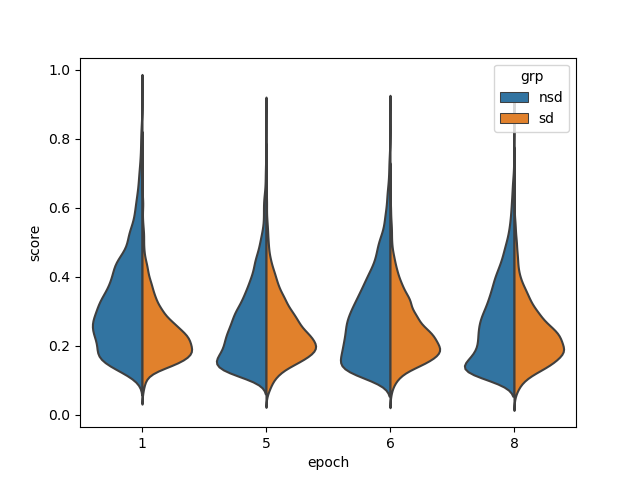

In [55]:
%matplotlib widget
import seaborn as sns

sns.violinplot(
    data=score_df,
    x="epoch",
    y="score",
    hue="grp",
    split=True,
    inner=None,
    scale="width",
)


### Decoding re-maze with maze template

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = (
    subjects.nsd.ratSday2
    + subjects.nsd.ratVday1
    + subjects.nsd.ratUday2
    + subjects.sd.ratSday3
    + subjects.sd.ratVday2
    + subjects.sd.ratUday4
)


In [73]:
from tqdm import tqdm

score_df = []
dist_replay_df=[]
for sub, sess in enumerate(tqdm(sessions)):
    re_maze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons.get_neuron_type(neuron_type="pyr")
    pos = sess.maze
    # run = sess.run
    pf = Pf1D(
        neurons=neurons,
        position=pos,
        speed_thresh=5,
        sigma=4,
        grid_bin=2,
        # epochs=run,
        frate_thresh=1,
    )
    pf_neurons = neurons.get_by_id(pf.neuron_ids)
    epochs = sess.pbe.time_slice(re_maze[0], re_maze[1])
    decode = Decode1d(
        neurons=pf_neurons,
        ratemap=pf,
        epochs=epochs,
        bin_size=0.02,
        decode_margin=15,
        nlines=5000,
    )
    jump_distance = [np.abs(np.diff(_)).mean() for _ in decode.decoded_position]

    norm_pos=min_max_scaler(decode.ratemap.xbin_centers)
    decoded_position_mean =np.nanmean(np.hstack(decode.posterior),axis=1)
    pos_bins = np.linspace(0,1,50)
    mean_pos = np.interp(pos_bins,norm_pos,decoded_position_mean) 

    df_dist = pd.DataFrame(
        dict(
            bins = pos_bins,
            mean_pos = mean_pos,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )

    df = pd.DataFrame(
        dict(
            score=decode.score,
            velocity=decode.velocity,
            jump_distance=jump_distance,
            epoch="re-maze",
            name=sess.animal.name,
            grp=sess.tag,
        )
    )
    score_df.append(df)
    dist_replay_df.append(df_dist)

score_df = pd.concat(score_df, ignore_index=True)
dist_replay_df=  pd.concat(dist_replay_df, ignore_index=True)
subjects.GroupData().save(score_df,'replay_re_maze_score')
subjects.GroupData().save(dist_replay_df,'replay_re_maze_position_distribution')

100%|██████████| 6/6 [01:56<00:00, 19.42s/it]

replay_re_maze_score saved
replay_re_maze_position_distribution saved


In [ ]:
%matplotlib widget
import seaborn as sns

sns.violinplot(
    data=score_df,
    x="epoch",
    y="score",
    hue="grp",
    split=True,
    inner=None,
    scale="width",
)


### Decoding theta sequences

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2

In [ ]:
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"]
    neurons = sess.neurons.get_neuron_type(neuron_type="pyr")
    pos = sess.lin_maze
    # pos.t_start = pos.t_start +0.5
    run = sess.run
    pf = Pf1D(
        neurons=neurons,
        position=pos,
        speed_thresh=4,
        sigma=4,
        grid_bin=2,
        # epochs=run,
        frate_thresh=1,
    )
    pf_neurons = neurons.get_by_id(pf.ratemap.neuron_ids)
    epochs = sess.pbe.time_slice(maze[0], maze[1])
    decode = Decode1d(
        neurons=pf_neurons, ratemap=pf.ratemap, epochs=epochs, bin_size=0.02,slideby=0.01
    )


In [ ]:
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot

# bplot.output_file(subjects.figpath_sd/'test_wake_decoding.html')
bplot.output_notebook()
p = plot_in_bokeh(x=epochs.starts/3600 - sess.paradigm['maze'][0]/3600,y=decode.score,img_arr=decode.spkcount,color_by=decode.score,palette='jet_r',size=10)
# p.line(pos.time,pos.x/350 + 0.2,line_width=2,color='black')
bplot.show(p)

### scratch code for pooled randon transform

In [ ]:
nbins = [_.shape[1] for _ in decode.posterior[:60]]
post = np.hstack(decode.posterior[:60])
arr = post
nlines=10000
dt=1
dx=1
neighbours=1
t = np.concatenate([np.arange(0,_) for _ in nbins])
max_t = max(nbins)
nt = len(t)
tmid = (nt + 1) / 2 - 1

pos = np.arange(arr.shape[0])
npos = len(pos)
pmid = (npos + 1) / 2 - 1

# using convolution to sum neighbours
arr = np.apply_along_axis(
    np.convolve, axis=0, arr=arr, v=np.ones(2 * neighbours + 1), mode="same"
)

# exclude stationary events by choosing phi little below 90 degree
# NOTE: angle of line is given by (90-phi), refer Kloosterman 2012
phi = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=nlines)
diag_len = np.sqrt((max_t - 1) ** 2 + (npos - 1) ** 2)
rho = np.random.uniform(low=-diag_len / 2, high=diag_len / 2, size=nlines)

rho_mat = np.tile(rho, (nt, 1)).T
phi_mat = np.tile(phi, (nt, 1)).T
t_mat = np.tile(t, (nlines, 1))
posterior = np.zeros((nlines, nt))

y_line = ((rho_mat - (t_mat - tmid) * np.cos(phi_mat)) / np.sin(phi_mat)) + pmid
y_line = np.rint(y_line).astype("int")

# if line falls outside of array in a given bin, replace that with median posterior value of that bin across all positions
t_out = np.where((y_line < 0) | (y_line > npos - 1))
t_in = np.where((y_line >= 0) & (y_line <= npos - 1))
posterior[t_out] = np.median(arr[:, t_out[1]], axis=0)
posterior[t_in] = arr[y_line[t_in], t_in[1]]

# old_settings = np.seterr(all="ignore")
posterior_mean = np.nanmean(posterior, axis=1)

best_line = np.argmax(posterior_mean)
score = posterior_mean[best_line]
best_phi, best_rho = phi[best_line], rho[best_line]
time_mid, pos_mid = nt * dt / 2, npos * dx / 2

velocity = dx / (dt * np.tan(best_phi))
intercept = (
    (dx * time_mid) / (dt * np.tan(best_phi))
    + (best_rho / np.sin(best_phi)) * dx
    + pos_mid
)
# np.seterr(**old_settings)

# return score, -velocity, intercept

